##### Arturo Perez 
##### Professor Koutsoukos 
##### CS 3891 Assignment 3
##### 20 February 2018 

## Preprocessing 
###### In this section we take care of preprocessing the MNIST data set.
We start by reading in the MNIST data set. We seperate the training and testing data into four buffers.

In [107]:
import os
import numpy as np
import struct
import matplotlib.pyplot as plt
from mnist import MNIST

# the training set is stored in this directory
path = "/Users/Arturo1/Desktop/Vanderbilt/2017-2018/Spring 2018/Deep Learning 3891/handwriting"

# load the MNIST data
mndata = MNIST(path)
train_images, train_labels = mndata.load_training() # training data
test_images, test_labels = mndata.load_testing() # testing data

We continue by reshaping/rescaling the images and labels of both the training and test data.

In [108]:
# convert to (28x28,1) column vector and divide by 255
training_size, test_size = 60000, 10000   

train_images = np.array(train_images[:training_size], dtype=float).transpose() / 255
train_labels = np.array(train_labels[:training_size], dtype=float)
test_images = np.array(test_images[:test_size], dtype=float).transpose() / 255
test_labels = np.array(test_labels[:test_size], dtype = float)
train_labels = np.reshape(train_labels, (training_size, 1))
test_labels = np.reshape(test_labels, (test_size, 1))

Because we want to predict whether a new image is equal to ID or not, we change the labels from train_labels and test_labels to be either 1 if they are equal to ID, or 0 if they are not. This will help us make our predictions later on and calculate the accuracy/error rates. In my case, ID is equal to 6. 

In [109]:
# student ID
ID = 6
# change the labels to either 0 or 1
def relabel(label):
    for l in label:
        if (l[0] == ID):
            l[0] = 1
        else:
            l[0] = 0
            
relabel(train_labels)
relabel(test_labels)

We complete preprocessing by creating smaller training sets of the training set for later use.

In [110]:
# creating smaller data sets of differing size and differing data
# subset1 of 10 samples
subsetOneImages = train_images[:,:10]
ID_labels1 = train_labels[:10,:]

# subset2 of 75 samples
subsetTwoImages = train_images[:,25:100]
ID_labels2 = train_labels[25:100,:]

# subset 3 of 1,000 samples
subsetThreeImages = train_images[:,200:1200]
ID_labels3 = train_labels[200:1200,:]

# subset 4 of 10,000 samples
subsetFourImages = train_images[:,10000:20000]
ID_labels4 = train_labels[10000:20000,:]

## Learning
###### In this section we use the vectorized implementation of the 2 layer Neural Network, plot the learning curve, and investigate the impact of the learning rate, sample sizes, and the number of hidden units.

Vectorized implementation of Logistic Gradient Descent with 2 layers. LGD function will also plot cost curve. The equations used respectively: 

###### Forward Propogation 
$z^{[1]} = w^{[1]}X + b^{[1]}$

$A^{[1]} = tanh(z^{[1]})$

$z^{[2]} = w^{[2]}A^{[1]} + b^{[2]}$

$A^{[2]} = \sigma (z^{[2]}) $

###### Backward Propogation 
$dZ^{[2]} = A^{[2]} - y$

$dW^{[2]} = {1 \over m} dZ^{[2]} A^{[1]T}$

$dB^{[2]} = {1 \over m} sum horizontally(dZ^{[2]}) $

$dZ^{[1]} = w^{[2]T} dZ^{[2]} * g^{[1]'}(Z^{[1]}) $

$dW^{[1]} = {1 \over m} dZ^{[1]} x^{T} $

$dB^{[1]} = {1 \over m} sum horizontally(dZ^{[1]}) $

###### Cost Function
$J(w,b) = -{1 \over m} \sum\limits_{1=1}^{m} (y log(a) + (1 - y)log(1 - a) $
###### Update Parameters

$ w = w - \alpha dW $

$ b = b - \alpha dB $

where $\alpha$ is the learning rate 

In [111]:
### Logistic Gradient Descent with 2 layers ###
def LGD(samples, X, y, alpha, n):
    #initialize our variables
    costs = []
    m = X.shape[1] 
    f = X.shape[0] 
    
    # n = number of neurons
    # f = number of features 
    # m = number of samples 
    w = [np.random.rand(n,f), np.random.rand(1,n)] 
    w[0] = w[0] * 0.01
    w[1] = w[1] * 0.01
    b = [np.random.rand(n,1), np.random.rand(1,1)] 
    b[0] = b[0] * 0.01
    b[1] = b[1] * 0.01 
    z = [np.zeros((n,m)), np.zeros((1,m))]
    a = [np.zeros((n,m)), np.zeros((1,m))]
    dZ = [np.zeros((n,m)), np.zeros((1,m))]
    dW = [np.zeros((f,n)), np.zeros((n,1))]
    dB = [np.zeros((n,1)), np.zeros((1,1))]

    for i in range(0,1000):

        # forward propopgation 
        z[0] = (w[0] @ X) + b[0]
        a[0] = np.tanh(z[0])
        z[1] = (w[1] @ a[0]) + b[1]
        a[1] = 1 / (1 + np.exp(-z[1]))

        #compute cost
        cost = 0
        cost = (-1/m) * np.sum(y * np.log(a[1]) + (1 - y) * np.log(1 - a[1]))
        costs.append(cost)

        #backward propogation 
        dZ[1] = a[1] - y
        dW[1] = (1/m) * (dZ[1] @ a[0].transpose())
        dB[1] = (1/m) * np.sum(dZ[1], axis = 1).reshape(dB[1].shape[0], dB[1].shape[1])
        dZ[0] = np.multiply((w[1].transpose() @ dZ[1]),(1-(np.tanh(z[0]**2))))
        dW[0] = (1/m) * (dZ[0] @ X.transpose())
        dB[0] = (1/m) * np.sum(dZ[0], axis = 1).reshape(dB[0].shape[0], dB[0].shape[1])

        #update parameters 
        w[1] = w[1] - (alpha * dW[1])
        b[1] = b[1] - (alpha * dB[1])
        w[0] = w[0] - (alpha * dW[0])
        b[0] = b[0] - (alpha * dB[0])

    # plot cost function
    plt.plot(costs)
    plt.title("Student ID Cost Function (" + str(samples) + " samples)")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    plt.show()

    return(w, b)

We investigate the impact of differing sized training sets, learning rates, and number of hidden units. As the learning rate alpha increases, the cost function become smoother and less bumpy. Data sets with larger sample sizes have rounder and smoother cost functions. Increasing the hidden units tends to get rid of bumps in the graph, and makes the graph smoother. The best and truest combination was 10,000 samples, alpha = 0.5, and hidden units = 10.

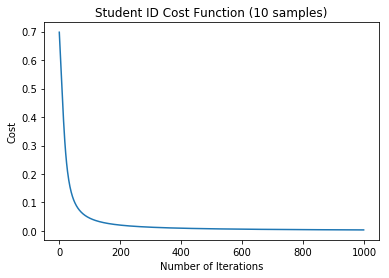

In [112]:
# investigate the impact of the training data size and the learning rate alpha 
w,b = LGD(10, subsetOneImages, ID_labels1.transpose(), .05, 5) #10 samples, alpha = .05, hidden units = 5

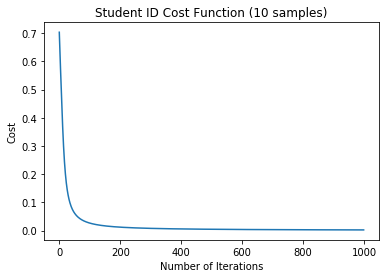

In [113]:
w,b = LGD(10, subsetOneImages, ID_labels1.transpose(), .05, 10) #10 samples, alpha = .05, hidden units = 10

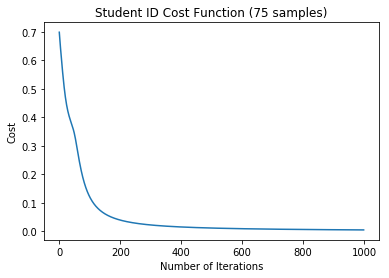

In [114]:
w,b = LGD(75, subsetTwoImages, ID_labels2.transpose(), .05, 5) #75 samples, alpha = .05, hidden units = 5

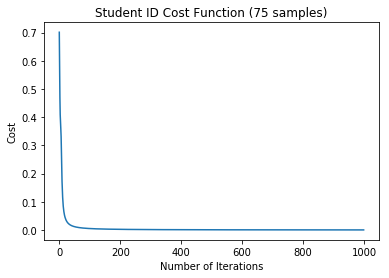

In [115]:
w,b = LGD(75, subsetTwoImages, ID_labels2.transpose(), .5, 5) #75 samples, alpha = .5, hidden units = 5

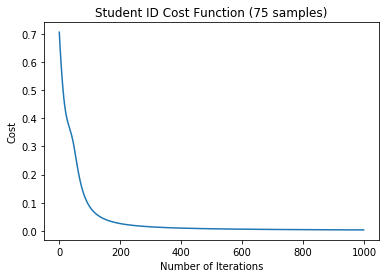

In [116]:
w,b = LGD(75, subsetTwoImages, ID_labels2.transpose(), .05, 10) #75 samples, alpha = .05, hidden units = 10

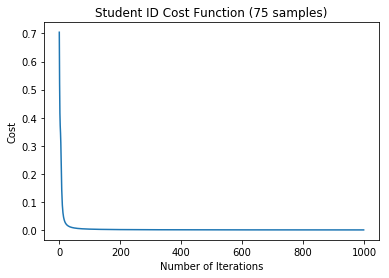

In [117]:
w,b = LGD(75, subsetTwoImages, ID_labels2.transpose(), .5, 10) #75 samples, alpha = .5, hidden units = 10

Notice how increasing both the hidden units and the learning rate leads to a smoother graph.

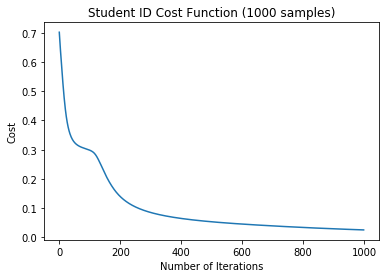

In [118]:
w,b = LGD(1000, subsetThreeImages, ID_labels3.transpose(), .05, 5) #1000 samples, alpha = .05, hidden units = 5

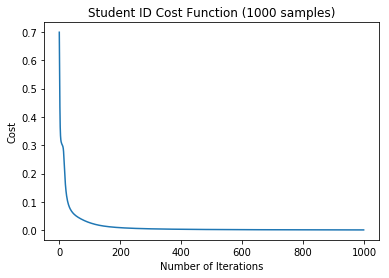

In [119]:
w,b = LGD(1000, subsetThreeImages, ID_labels3.transpose(), .5, 5) #1000 samples, alpha = .5, hidden units = 5

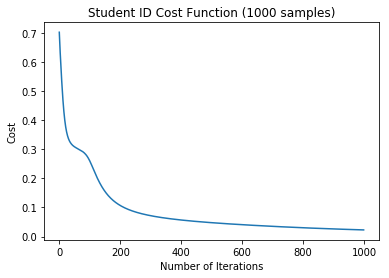

In [120]:
w,b = LGD(1000, subsetThreeImages, ID_labels3.transpose(), .05, 10) #1000 samples, alpha = .05, hidden units = 10

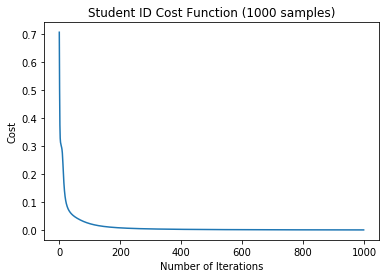

In [121]:
w,b = LGD(1000, subsetThreeImages, ID_labels3.transpose(), .5, 10) #1000 samples, alpha = .5, hidden units = 10

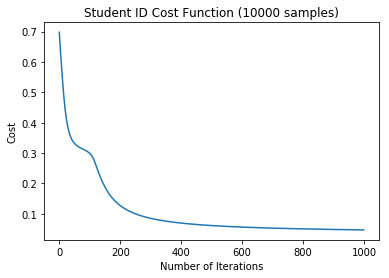

In [122]:
w,b = LGD(10000, subsetFourImages, ID_labels4.transpose(), .05, 5) #10000 samples, alpha = .05, hidden units = 5

This bumpy graph can be explained by a small learning rate (which can lead to convergence issues) and a small amount of hidden units.

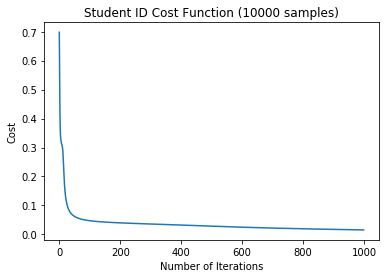

In [123]:
w,b = LGD(10000, subsetFourImages, ID_labels4.transpose(), .5, 5) #10000 samples, alpha = .5, hidden units = 5

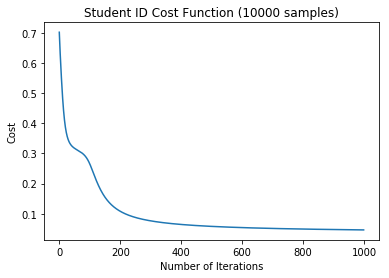

In [124]:
w,b = LGD(10000, subsetFourImages, ID_labels4.transpose(), .05, 10) #10000 samples, alpha = .05, hidden units = 10

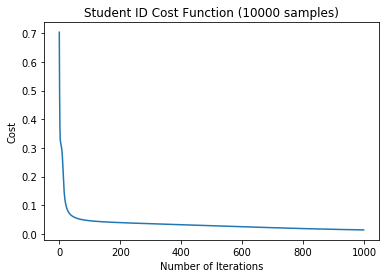

In [125]:
w,b = LGD(10000, subsetFourImages, ID_labels4.transpose(), .5, 10) #10000 samples, alpha = .5, hidden units = 10

An (almost) smooth graph thanks to a large learning rate and large amount of hidden units.

## Evaluation

We will now train the model with all 60,000 samples to get weights w and b respectively.

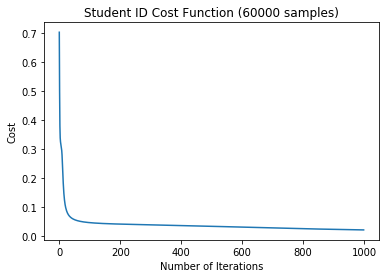

In [126]:
w, b = LGD(60000, train_images, train_labels.transpose(), .5, 10) #alpha = .5, hidden units = 10

We now test our weights w and b with the test images and generate aTest[1], which we will use to compute our accuracy and error rates. 

In [127]:
# compute the training and the test error
#initialize our zTest and aTest
m = test_images.shape[1]
zTest = [np.zeros((5,m)), np.zeros((1,m))]
aTest = [np.zeros((5,m)), np.zeros((1,m))]

zTest[0] = (w[0] @ test_images) + b[0]
aTest[0] = np.tanh(zTest[0])
zTest[1] = (w[1] @ aTest[0]) + b[1]
aTest[1] = 1 / (1 + np.exp(-zTest[1]))

Using aTest[1], we compute our accuracy and error rates. We first send all the values of aTest[1] to be either 1 or 0, then compare aTestLabels to test_labels and keep a count of the number of similarities between aTestLabels and test_labels. The higher our similarity count, the better our model is predicting. We will keep track of mismatches in the lists misclassified and misclassifiedTag to later examine possible reasons our model misclassified certain inputs. 

In [128]:
aTestLabels = np.array([1 if a > .5 else 0 for a in aTest[1].T])

count = 0
misclassified = []
misclassifiedTag = []
for i in range(1,10000):
    if aTestLabels[i] == test_labels[i]:
        count += 1
    else:
        misclassified.append(i)
        misclassifiedTag.append(aTestLabels[i])

We then calculate and print the respective accuracy and error rates as predicted by our model.

In [129]:
accuracy = (count/10000) * 100
error_rate = 100 - accuracy
        
print("accuracy for ID = " + str(ID) + " is : " + str(accuracy) + "%")
print("error rate for ID = " + str(ID) + " is : " + str(error_rate) + "%")

accuracy for ID = 6 is : 99.21%
error rate for ID = 6 is : 0.7900000000000063%


We conclude by trying test examples. We reload the mnist data set again because the package I used above to load mnist brought the mnist images already flattened, and we need them to be not flattened so I can display them. I took certain samplings from the list misclassified to examine possible reasons these inputs "fooled" our model. 

In [130]:
# load unflattened mnist images to display
path = "/Users/Arturo1/Desktop/Vanderbilt/2017-2018/Spring 2018/Deep Learning 3891/handwriting"   # the training set is stored in this directory
fname_test_images = os.path.join(path, 't10k-images-idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 't10k-labels-idx1-ubyte')  # the training set label file path
    
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    testlabels = np.fromfile(flbl, dtype=np.uint8)

with open(fname_test_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    testimages = np.fromfile(fimg, dtype=np.uint8).reshape(len(testlabels), rows, cols)       


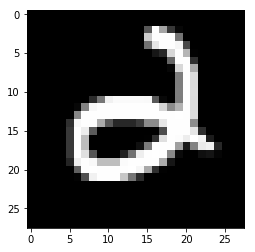

1
MISCLASSIFIED - NOT A 6


In [146]:
plt.imshow(testimages[misclassified[16]], cmap='gray')  # plot the image in "gray" colormap
plt.show()
print(misclassifiedTag[16])
print("MISCLASSIFIED - NOT A 6")

The model must have mistakened the loop of the 2 to be the loop of a 6.

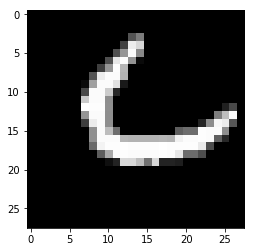

0
MISCLASSIFIED - THIS IS 6


In [132]:
plt.imshow(testimages[misclassified[48]], cmap='gray')  # plot the image in "gray" colormap
plt.show()
print(misclassifiedTag[48])
print("MISCLASSIFIED - THIS IS 6")

The inner loop of the 6 is compressed and not noticable in this test image. If anything, this resembles more the letter C than the number 6. 

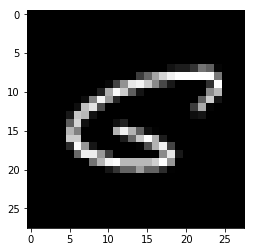

0
MISCLASSIFIED - THIS IS 6


In [133]:
plt.imshow(testimages[misclassified[7]], cmap='gray')  # plot the image in "gray" colormap
plt.show()
print(misclassifiedTag[7])
print("MISCLASSIFIED - THIS IS 6")

The inner loop of the 6 is disconnected from the rest of the number. Again, this resembles more the letter G than the letter 6. 

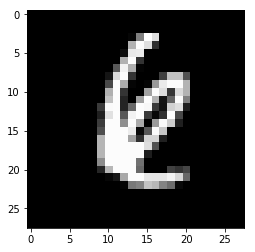

0
MISCLASSIFIED - THIS IS 6


In [134]:
plt.imshow(testimages[misclassified[8]], cmap='gray')  # plot the image in "gray" colormap
plt.show()
print(misclassifiedTag[8])
print("MISCLASSIFIED - THIS IS 6")

The tail hanging of the 6 must makes this number ambiguous and must have confused the model, even though the rest of the number resembles a 6. 

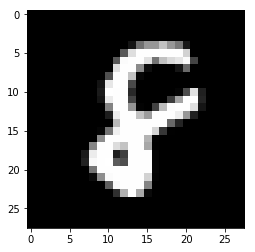

1
MISCLASSIFIED - NOT A 6


In [149]:
plt.imshow(testimages[misclassified[55]], cmap='gray')  # plot the image in "gray" colormap
plt.show()
print(misclassifiedTag[55])
print("MISCLASSIFIED - NOT A 6")

To the naked eye this is clearly an 8. The model must have confused the open loop at the top and the closed loop at the bottom to possibly be the construction of a 6. 